                                                                                                Patricia Grau Francitorra

# Assignment 1: Chinese character "detection"

**Introduction**

Optical character recognition is an old "AI" and image-processing task.  What it involves is taking a photograph or scan of a piece of text (printed or handwritten) and turning the characters (as images) into character codes on the computer that therefore allow the text to be edited, indexed, etc.  A key part of that process is identifying where the characters actually are, especially if the characters are mixed among other non-writing, such as images of objects or people.

In this assignment, you will **take images from a Chinese image database with annotations that indicate where the Chinese characters are, and you will train a model that takes test images, and superimposes upon them a visualization (of your choosing, e.g., a "heat map") of the likelihood that a pixel is close to or part of a valid Chinese character**.  The image database contains annotations of "bounding boxes", coordinates of the corners of a box that contains a single Chinese character.  In a sense, this assignment asks you to detect the bounding boxes in test images without the annotation, but a softer version of this: simply to **provide the probability, for each pixel, whether that pixel was part of a bounding box containing a Chinese character**.  Then, you are to 
   1. **superimpose upon the image a pixel-based map of likelihoods of where the bounding boxes ought to be** and
   2. **apply an evaluation statistic**.

This assignment grants you a lot of freedom in how you organize your code and set up the task overall.  Because of the degree of freedom it involves, it will mostly be graded on our evaluation of the effort put into the solution.  An actual high success at the task is not a requirement to get a high grade.  However, you will have to **report in detail**, in your own format, what you did, why you did it, how to run it -- it must run on mltgpu, be implemented in Python using PyTorch, and make use of the GPUs -- and how to apply it easily to our own test images.

You will have almost a month to do this assignment, even though it is worth only 30% of your grade.  Another assignment with 30% will be given out for the last/remaining two weeks of the study period.   These time periods are coextensive with that of the project, but we expect you to be able to schedule your time well enough to put in an effort at both. This assignment is officially due at 23:59 on 2021 October 18. There are 30 points on this assignment, and a maximum of 20 bonus points.

**The data**

The source of the task is here: https://ctwdataset.github.io/ (Links to an external site.) They have example images and an example of a baseline task that is much more advanced than what we are doing, but it will give you an idea of the data format, particularly the metadata.  Pay attention especially to the "Annotation format" section of this page: https://ctwdataset.github.io/tutorial/1-basics.html (Links to an external site.)

The metadata and a small sample of the whole image dataset is available at /scratch/lt2326-h21/a1 on mltgpu. The metadata is in json format.  info.json contains information about every image file.  We will unzip only a minority of the original training image files.  train.jsonl is a list of json entities, one per line (that have to be parsed with the json package each separately) that correspond to the files in info.json.  This contains the bounding box information, as well as other information for the original challenge on the web.  See the "Annotation format" section mentioned on the dataset web page linked above.

## Part 1: data preparation (7 points)

The image files are in /scratch/lt2326-h21/a1/images on mltgpu. They are in jpg format.  The code that you write for this part of the project should:

- Use the info.json file to figure out what files are in the training set.  You will just use the official training data for everything.  Remember that you will only see a small minority of training examples in the images directory, for space reasons.
- Divide up the official training data files into your own training, validation, and test datasets depending on your own preferences. You can choose to use fewer files than the maximum available if you run into problems with memory and so on (but first make sure your implementation is reasonably efficient).
- Find the corresponding bounding box information in train.jsonl for each image. 

You can represent the data in any way you like, but remember that **it will become a numpy array for processing and a torch tensor for training**.  Remember also that **the classes are defined by pixel: for each pixel, you will eventually have a set of features (e.g. colour values), and a binary class corresponding to whether the pixel was in a Chinese character bounding box or not (note that there are non-Chinese characters in the set -- see the annotation instructions)**.  You are allowed to **reduce the dimensionality of the images for processing, but consider using a pooling and/or upsampling technique in Part 2** of this assignment to accomplish this goal. 

Describe the choices you made and the challenges you found in your report.

In [1]:
import os, sys
from os import listdir
from PIL import Image
import numpy as np
import json
import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.path as mplpath

from skimage import transform

import random

from torch.utils.data import DataLoader

import time
from joblib import Parallel, delayed

In [2]:
# some info

# Opening JSON file
f = open('/scratch/lt2326-h21/a1/info.json',)

# returns JSON object as a dictionary
info = json.load(f)

# print(info.keys())
# print(info['train'][0])
# print(len(info['train']))

# gets the names of the images in train
im_in_train = []
for a in info['train']:
    name = a['image_id'] + '.jpg'
    im_in_train.append(name)

# Closing file
f.close()

In [3]:
with open('/scratch/lt2326-h21/a1/train.jsonl') as trainfile:
    traindata = [json.loads(x) for x in trainfile]

# let's take a look at the traindata
# traindata[0]

In [4]:
# print(im_in_train)
# checking what images are in the images folder

path = '/scratch/lt2326-h21/a1/images'
dirs = os.listdir(path)

usable_img_names = []
for img_name in dirs:
    if img_name in im_in_train:
        usable_img_names.append(img_name)
print('There are', len(usable_img_names), 'images in the image folder that come from the train file.')

# only taking the images that are in the folder

usable_data = []
for e in traindata:
    if e['file_name'] in usable_img_names:
        usable_data.append(e)

# print(usable_data[0])

There are 845 images in the image folder that come from the train file.


In [5]:
# separating data into training, testing and validation data
# the train set consists of 80% of the data, test and validation sets are 10% of the data

random.shuffle(usable_data)

usable_train, usable_test, usable_val = np.split(usable_data, [int(len(usable_data)*0.8), int(len(usable_data)*0.9)])

print(len(usable_train), len(usable_test), len(usable_val)) # sanity test

676 84 85


In [6]:
# we have usable_train, a list that contains dictionaries for each image
# {image_id1 : {'chinese' : [[poligon 1], [poligon2]], 'non_chinese' : [[poligon 1], [poligon2]]}, image_id2 : {'chinese' : [pol1], [pol2], [pol3]], 'non_chinese': []...}...}
# We will have all the polygons of every image, the ones that contain chinese characters and the ones that don't

def get_chinese(some_usable):
    chinese_im = {}
    
    for image in some_usable:
        chinese_im[image['image_id']] = {'chinese' : [], 'non_chinese' : []}
        for anno in image['annotations']:
            for a in anno:
                if a['is_chinese']:
                    chinese_im[image['image_id']]['chinese'].append(a['polygon'])
                else:
                    chinese_im[image['image_id']]['non_chinese'].append(a['polygon'])
    return chinese_im

In [7]:
chi_train = get_chinese(usable_train)
chi_test = get_chinese(usable_test)
chi_val = get_chinese(usable_val)

train_im_names = list(chi_train.keys())
test_im_names = list(chi_test.keys())
val_im_names = list(chi_val.keys())

In [16]:
# getting the gold values for just one image

# making an empty grid
grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
grid.shape = (2048*2048, 2)

# taking all polygons of 1 image
pols = []
for pol in chi_train['1000193']['chinese']:
    pols.append(pol)

# getting the path for each polygon and updating the grid

zeros = np.zeros(2048*2048)
for pol in pols:
    pol_path = mplpath.Path(pol)
    truthvals = pol_path.contains_points(grid)
    # turning it into 0s and 1s    
    truthvals = np.asarray(truthvals, int)
    # updating
#     zeros = zeros + truthvals
    zeros = np.maximum(truthvals, zeros)

# this is inefficient af but it works so I need to look for a better solution
# bool_arr = np.array(zeros, dtype=bool)
# canviem = np.asarray(bool_arr, int)

# checking that there are no pixels with a value different than 1 or 0
# n = 0
# for e in zeros:
#     if e == 1:
#         n+=1
# #     elif e >= 1:
# #         print('oops', e)
# print(n)

# zeros.shape = (2048, 2048)
# canviem.shape = (2048, 2048)

ten = torch.Tensor(zeros)
print(ten.size())
ten
# canviem

torch.Size([4194304])


tensor([0., 0., 0.,  ..., 0., 0., 0.])

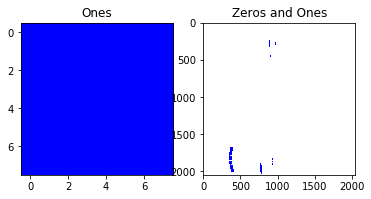

In [12]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Random matrix

data_ones = np.random.randint(1, 2, size=(8, 8))
# data_both = np.random.randint(0, 2, size=(8, 8))

# Define colormap

cmapmine = ListedColormap(['w', 'b'], N=2)

# Plot matrix

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data_ones, cmap=cmapmine, vmin=0, vmax=1)
ax1.set_title('Ones')
ax2.imshow(zeros, cmap=cmapmine, vmin=0, vmax=1)
ax2.set_title('Zeros and Ones')
plt.show()

In [11]:
def loadImages1(path, train_names, test_names, val_names):
    imagesList = listdir(path)
    
    loadedImages_train = []
    loadedImages_test = []
    loadedImages_val = []
    
    for image in imagesList:
        img = Image.open(path + "/" + image)
        if image[:-4] in train_names:
            loadedImages_train.append(img)
        elif image[:-4] in test_names:
            loadedImages_test.append(img)
        elif image[:-4] in val_names:
            loadedImages_val.append(img)

    return loadedImages_train, loadedImages_test, loadedImages_val

In [ ]:
loadedIm1 = loadImages(path, train_im_names, test_im_names, val_im_names) # OSError: [Errno 24] Too many open files: '/scratch/lt2326-h21/a1/images'

In [117]:
trainImages, testImages, valImages = loadedIm1
len(trainImages)

676

In [118]:
def fromImagesToTensors(loadedImages, device):
    
    tensors = torch.unsqueeze(torch.tensor(np.array(loadedImages[0])), 0)
    for im in loadedImages[1:]:
        im_numpy = np.array(im)
        im_torch = torch.tensor(im_numpy) # size of [2048, 2048, 3]
        im_torch_1d = torch.unsqueeze(im_torch, 0)
        # im_torch_gpu = im_torch_1d.to(device)
        tensors = torch.cat((tensors, im_torch_1d), 0)
    
    tensors_gpu = tensors.to(device)
    return tensors_gpu

# fromImagesToTensors(crap, device)

gettingTensors = fromImagesToTensors(trainImages, device)
gettingTensors.size()

torch.Size([676, 2048, 2048, 3])

In [119]:
# gettingTensors

tensor([[[[140, 178, 225],
          [140, 178, 225],
          [140, 178, 225],
          ...,
          [ 95, 136, 192],
          [ 96, 137, 193],
          [ 96, 137, 193]],

         [[140, 178, 225],
          [140, 178, 225],
          [140, 178, 225],
          ...,
          [ 96, 137, 193],
          [ 96, 137, 193],
          [ 96, 137, 193]],

         [[139, 177, 224],
          [140, 178, 225],
          [140, 178, 225],
          ...,
          [ 96, 137, 193],
          [ 96, 137, 193],
          [ 96, 137, 193]],

         ...,

         [[127, 124, 119],
          [125, 122, 117],
          [122, 119, 114],
          ...,
          [105, 106, 101],
          [ 92,  93,  88],
          [ 76,  77,  72]],

         [[146, 143, 136],
          [133, 130, 125],
          [122, 119, 114],
          ...,
          [109, 110, 105],
          [104, 105, 100],
          [ 99, 100,  95]],

         [[129, 126, 119],
          [119, 116, 109],
          [109, 106, 101],
         

In [10]:
# working on this again to get smaller images
def loadImagesAndTensors(path, train_names, test_names, val_names, device):    
    imagesList = listdir(path)
    
    train_tensors = []
    test_tensors = []
    val_tensors = []
    
    for image in imagesList:
        # loading the image
        fullimg = mpimg.imread(path + "/" + image)
        img = transform.resize(fullimg, (200,200))
        
        # making it a tensor
        timg = torch.tensor(img).to(device)
        timg = timg.float()
        
        # preparing it for a conv layer
        permute = timg.permute((2, 0, 1)).to(device)
        unsqueezeme = permute.unsqueeze(0).to(device)
        
        # separating into train, test and val
        if image[:-4] in train_names:
            train_tensors.append(unsqueezeme)
        elif image[:-4] in test_names:
            test_tensors.append(unsqueezeme)
        elif image[:-4] in val_names:
            val_tensors.append(unsqueezeme)

    return train_tensors, test_tensors, val_tensors
    

In [11]:
# device = torch.device("cpu")
device = torch.device("cuda:0")

In [12]:
train_tensors, test_tensors, val_tensors = loadImagesAndTensors(path, train_im_names, test_im_names, val_im_names, device)

In [16]:
def goldValuesThatDoesntFuckingWork(chi_data, imgsize, device):
    """
    Creates matrices corresponding to images with 1 values where 
    there are polygons containing chinese characters and 0 where 
    there aren't.
    
    Args:
        chi_data: output from get_chinese, a dictionary containing 
          the name of the images and the points where polygons 
          containing chinese and non_chinese characters are. 
          Example: {image_id1 : {'chinese' : [[poligon 1], [poligon2]], '
          non_chinese' : [[poligon 1], [poligon2]]}, image_id2 : 
          {'chinese' : [pol1], [pol2], [pol3]], 'non_chinese': []...}...}
        imgsize: size of the input image
        
    Returns:
        a list withthe gold values of the pixels of the image; 
        matrices with 1 values where there is a chinese character 
        (inside the polygons) and 0 where there aren't.
        
    """
    l = []
    
    for image in chi_data:
        
        # taking all polygons of 1 image
        pols = []
        for pol in chi_data[image]['chinese']:
            pols.append(pol)
        
        # making an empty grid
        grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
        grid.shape = (imgsize*imgsize, 2)

        # getting the path for each polygon and updating a 0 matrix
        zeros = np.zeros(imgsize*imgsize)
        for pol in pols:
            pol_path = mplpath.Path(pol)
            truthvals = pol_path.contains_points(grid)
            
            # turning it into 0s and 1s    
            truthvals = np.asarray(truthvals, int)
            
            # updating
            # we take the maximum in case there is the same pixel in different polygons
            zeros = np.maximum(truthvals, zeros)

        zeros.shape = (imgsize, imgsize)
        
        ten = torch.Tensor(zeros).to(device)

        l.append(ten)
    return l

In [13]:
# idea, same as before, but flat 2048*2048
def goldValues(chi_data, imgsize):
    """
    Creates matrices corresponding to images with 1 values where 
    there are polygons containing chinese characters and 0 where 
    there aren't.
    
    Args:
        chi_data: output from get_chinese, a dictionary containing 
          the name of the images and the points where polygons 
          containing chinese and non_chinese characters are. 
          Example: {image_id1 : {'chinese' : [[poligon 1], [poligon2]], '
          non_chinese' : [[poligon 1], [poligon2]]}, image_id2 : 
          {'chinese' : [pol1], [pol2], [pol3]], 'non_chinese': []...}...}
        imgsize: size of the input image
        
    Returns:
        a list withthe gold values of the pixels of the image; 
        matrices with 1 values where there is a chinese character 
        (inside the polygons) and 0 where there aren't.
        
    """
    l = []
    
    # making an empty grid
    grid = np.array([[[a,b] for b in list(range(imgsize))] for a in list(range(imgsize))])
    grid.shape = (imgsize*imgsize, 2)
    
    for image in chi_data:

        # getting the path for each polygon and updating a 0 matrix
        zeros = np.zeros(imgsize*imgsize)
        
        for pol in chi_data[image]['chinese']:
            pol_path = mplpath.Path(pol)
            truthvals = pol_path.contains_points(grid)
            
            # turning it into 0s and 1s    
            truthvals = np.asarray(truthvals, int)
            
            # updating
            # we take the maximum in case there is the same pixel in different polygons
            zeros = np.maximum(truthvals, zeros)
        
#         ten = torch.Tensor(zeros).to(device)

        l.append(zeros)
    return torch.FloatTensor(l)

In [14]:
# device = torch.device("cuda:1")
train_gold = goldValues(chi_train, 2048).to(device)

AttributeError: 'list' object has no attribute 'to'

In [8]:
# just for one image
def imageAndTensor(image):  
    path = '/scratch/lt2326-h21/a1/images'
    
    # loading the image
    fullimg = mpimg.imread(path + "/" + image + ".jpg")
    img = transform.resize(fullimg, (200,200))

    # making it a tensor
    timg = torch.tensor(img)
    timg = timg.float()

    # preparing it for a conv layer
    permute = timg.permute((2, 0, 1))
    # unsqueezeme = permute.unsqueeze(0).to(device)

    return permute

In [9]:
# just one image
def ImageGoldValues(chi_data, image):
   
    # making an empty grid
    grid = np.array([[[a,b] for b in list(range(2048))] for a in list(range(2048))])
    grid.shape = (2048*2048, 2)

    # getting the path for each polygon and updating a 0 matrix
    zeros = np.zeros(2048*2048)

    for pol in chi_data[image]['chinese']:
        pol_path = mplpath.Path(pol)
        truthvals = pol_path.contains_points(grid)

        # turning it into 0s and 1s    
        truthvals = np.asarray(truthvals, int)

        # updating
        # we take the maximum in case there is the same pixel in different polygons
        zeros = np.maximum(truthvals, zeros)

    return torch.LongTensor(zeros)

In [10]:
device = torch.device("cuda:3")

In [11]:
def process_images_in_parallel(chi_data, image):
    return (imageAndTensor(image), 
            ImageGoldValues(chi_data, image))

In [12]:
start = time.time()
processed_data = Parallel(n_jobs = 10)(delayed(process_images_in_parallel)(chi_train, image) for image in chi_train)
end = time.time()

print("Processing data took", round(end-start, 0), "seconds")

Processing data took 1477.0 seconds


In [57]:
device = torch.device("cpu")
qwerty = imageAndTensor('0000566')
uiop = ImageGoldValues(chi_train, '0000566')
uiop.size()

torch.Size([4194304])

## Part 2: the models (10 points)

In this part, you will implement two substantially different model archictectures, that both take your representation of the images as training input and both take your representation of the bounding boxes as objective (HINT: the binary classification of pixels as belonging to a bounding box or not).  They will save the trained models to files so that they can be loaded and tested later. The output of the models will be a "soft binary" -- the probability of each pixel being inside a bounding box, from 0 to 1.  Consider examining some of the training data before designing your architectures.

You have a large grant of freedom as to what these model architectures will look like (remember: grading is on a "reasonable effort" basis).  There's a high chance (HINT) that they will both use **one or more convolutional layers**, among other things.  Describe the models and the motivations for the architecture in your report.

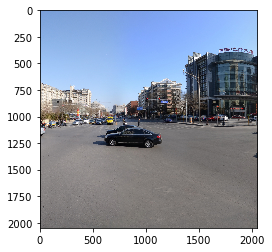

In [35]:
# this is just because I want to see an image

img = mpimg.imread("/scratch/lt2326-h21/a1/images/1000193.jpg")
%matplotlib inline

plt.imshow(img)

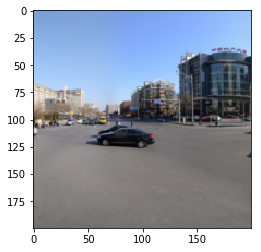

In [36]:
imgfull = img
img = transform.resize(img, (200,200))
plt.imshow(img)

In [40]:
device = torch.device("cpu")
# should I change the input and output channels in the convolutional layers?
conv1 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1)).to(device)

img = transform.resize(img, (200,200))
timg = torch.tensor(img).to(device)
timg = timg.float()
permute = timg.permute((2, 0, 1)).to(device)
unsqueezeme = permute.unsqueeze(0).to(device)
# unsqueezeme = timg.unsqueeze(0).to(device)

trying_conv1 = conv1(unsqueezeme).to(device)
trying_conv1.size()

torch.Size([1, 3, 200, 200])

In [100]:
unsqueezeme.size()

torch.Size([1, 3, 200, 200])

In [17]:
relu1 = nn.ReLU().to(device)
trying_relu1 = relu1(trying_conv1).to(device)

In [18]:
pool1 = nn.MaxPool2d(2).to(device)
trying_pool1 = pool1(trying_relu1).to(device)

/usr/local/lib64/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [19]:
conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1)).to(device)
trying_conv2 = conv2(trying_pool1).to(device)
trying_conv2.size()

torch.Size([1, 3, 100, 100])

In [20]:
relu2 = nn.ReLU().to(device)
trying_relu2 = relu2(trying_conv2).to(device)

In [21]:
pool2 = nn.MaxPool2d(2).to(device)
trying_pool2 = pool2(trying_relu2).to(device)
trying_pool2.size()

torch.Size([1, 3, 50, 50])

In [22]:
# what in features and out features am I supposed to put?
flat = trying_pool2.reshape(3*50*50)
fc1 = nn.Linear(3*50*50, 1*50*50).to(device)
trying_fc1 = fc1(flat).to(device)
trying_fc1.size()

torch.Size([2500])

In [23]:
relu3 = nn.ReLU().to(device)
trying_relu3 = relu3(trying_fc1).to(device)

In [24]:
fc2 = nn.Linear(50*50, 500).to(device)
trying_fc2 = fc2(trying_relu3).to(device)
trying_fc2.size()

torch.Size([500])

In [25]:
relu4 = nn.ReLU().to(device)
trying_relu4 = relu4(trying_fc2).to(device)

In [26]:
fc3 = nn.Linear(500, 100).to(device)
trying_fc3 = fc3(trying_relu4).to(device)
trying_fc3.size()

torch.Size([100])

In [27]:
relu5 = nn.ReLU().to(device)
trying_relu5 = relu5(trying_fc3).to(device)

In [28]:
stuff = trying_relu5.reshape((10, 10, 1))
stuff = stuff.permute((2, 0, 1))
stuff

tensor([[[0.0000e+00, 0.0000e+00, 4.2076e-02, 9.3034e-03, 1.0418e-02,
          0.0000e+00, 0.0000e+00, 3.5258e-02, 0.0000e+00, 7.4245e-03],
         [0.0000e+00, 2.6352e-02, 0.0000e+00, 4.9211e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 5.9034e-02, 2.4481e-02, 3.2367e-02],
         [0.0000e+00, 0.0000e+00, 2.7907e-03, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 4.3252e-02, 3.1167e-02, 5.2797e-02, 0.0000e+00],
         [4.1062e-02, 0.0000e+00, 0.0000e+00, 5.7870e-03, 1.3970e-02,
          4.2238e-02, 2.4881e-03, 0.0000e+00, 0.0000e+00, 0.0000e+00],
         [0.0000e+00, 2.3127e-02, 3.8128e-02, 1.6247e-02, 3.4405e-02,
          4.0125e-02, 0.0000e+00, 1.5917e-02, 7.6028e-03, 0.0000e+00],
         [0.0000e+00, 4.9866e-03, 4.3014e-02, 0.0000e+00, 2.7418e-02,
          0.0000e+00, 0.0000e+00, 1.3224e-02, 7.5223e-03, 2.0015e-02],
         [2.7199e-02, 1.6925e-02, 2.1584e-03, 9.5901e-03, 0.0000e+00,
          1.2051e-02, 0.0000e+00, 0.0000e+00, 1.9223e-03, 0.0000e+00],
         [0.0

In [29]:
stuff.size()

torch.Size([1, 10, 10])

In [30]:
squeezedstuff= stuff.unsqueeze(0).to(device)

In [31]:
squeezedstuff.size()

torch.Size([1, 1, 10, 10])

In [32]:
# asterisk or comma in Upsample?
makingbig = nn.Upsample((2048,2048)).to(device)
bigstuff = makingbig(squeezedstuff).to(device)
bigstuff.size()

torch.Size([1, 1, 2048, 2048])

In [33]:
bla = bigstuff.squeeze(1)
bla.size()

torch.Size([1, 2048, 2048])

In [34]:
# try this
finalflat = bla.reshape(2048*2048)
finalflat.size()

torch.Size([4194304])

In [26]:
# The first model will be based in LeNet (1998), because baby steps y'know?
# idea: two conv layers and three fully connected layers
class FirstModel0(nn.Module):
    def __init__(self):
        super(FirstModel0, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(3*50*50, 1*50*50)
        self.relu3 = nn.ReLU()
        
        self.linear2 =  nn.Linear(50*50, 500)
        self.relu4 = nn.ReLU()
        
        self.linear3 = nn.Linear(500, 100)
        self.relu5 = nn.ReLU()
        
        self.upsampling = nn.Upsample((2048,2048))
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        
#         y = y.reshape(3*50*50)
        y = y.view(y.shape[0], -1)
        
        y = self.linear1(y)
        y = self.relu3(y)
        
        y = self.linear2(y)
        y = self.relu4(y)
        
        y = self.linear3(y)
        y = self.relu5(y)
        
        reshaping = y.reshape((10, 10, 1))
        reshaping = reshaping.permute((2, 0, 1))
        
        squeezing= reshaping.unsqueeze(0).to(device)
        bigboi = upsampling(squeezing).to(device)
        output = bigboi.permute((1, 2, 0))
        output = output.reshape(2048*2048)
        
        return output

In [69]:
# The first model will be based in LeNet (1998), because baby steps y'know?
# idea: two conv layers and three fully connected layers
class FirstModel(nn.Module):
    def __init__(self):
        super(FirstModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.linear1 = nn.Linear(3*50*50, 1*50*50)
        self.relu3 = nn.ReLU()
        
        self.linear2 =  nn.Linear(50*50, 500)
        self.relu4 = nn.ReLU()
        
        self.linear3 = nn.Linear(500, 100)
        self.relu5 = nn.ReLU()
        
        self.upsampling = nn.Upsample((2048,2048))
    
    def forward(self, x):
        y = self.conv1(x)
        y = self.relu1(y)
        y = self.pool1(y)
        
        y = self.conv2(y)
        y = self.relu2(y)
        y = self.pool2(y)
        
#         y = y.reshape(3*50*50)
        y = y.view(y.shape[0], -1)
        
        y = self.linear1(y)
        y = self.relu3(y)
        
        y = self.linear2(y)
        y = self.relu4(y)
        
        y = self.linear3(y)
        y = self.relu5(y)
        
        reshaping = y.reshape((4, 10, 10, 1))
        reshaping = reshaping.permute((0, 3, 1, 2)) # [4, 1, 10, 10]
        
#         squeezing= reshaping.unsqueeze(0).to(device)
#         bigboi = self.upsampling(squeezing).to(device)
        bigboi = self.upsampling(reshaping) # [4, 1, 2048, 2048]?
        output = bigboi.permute((0, 2, 3, 1)) #[4, 2048, 2048, 1]?
        output = output.reshape(4, 2048*2048)
        
        return output

In [14]:
device = torch.device("cuda:3")

In [70]:
firstmodel = FirstModel().to(device)

In [40]:
firstmodel0 = FirstModel0().to(device)

In [16]:
# hyperparameters
device = torch.device('cuda:3')

batch_size = 4
learning_rate = 0.001
epochs = 5

In [17]:
train_dataloader = DataLoader(processed_data, batch_size=batch_size, shuffle=True)

In [87]:
def train(model, train_dataloader, device):
    loss = nn.CrossEntropyLoss()
#     loss = nn.LogSoftmax()
    optimizer = optim.Adam(FirstModel().parameters(), lr=learning_rate)
    
    model.train()

    for e in range(epochs):
        epoch_loss = 0
        
        for i, (tensors, matrix) in enumerate(train_dataloader):
            tensors = tensors.to(device)
            matrix = matrix.long().to(device)

            output = model(tensors)
            print(output.size())
            print(matrix.size())
            
            batch_loss = loss(output, matrix)
            epoch_loss += batch_loss.item()
            
            print(epoch_loss/(i+1), end='\r')
            
            batch_loss.backward()
            
            optimizer.step()
            
            optimizer.zero_grad()
        
        print()
        
    return model

In [89]:
m1 = train(firstmodel, train_dataloader, device)

torch.Size([4, 4194304])
torch.Size([4, 4194304])


RuntimeError: multi-target not supported at /pytorch/aten/src/THCUNN/generic/ClassNLLCriterion.cu:15

In [84]:
# torch.save(m1, 'firstmodel.pt')
# 16777216/4194304
67108864/4194304
import math
math.sqrt(4194304)

2048.0

In [ ]:
# AlexNet
# https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
class SecondModel(nn.Module):
    def __init__(self):
        super(SecondModel, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm1 = nn.BatchNorm2d(TODO)
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm2 = nn.BatchNorm2d(TODO)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv3 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm3 = nn.BatchNorm2d(TODO)
        
        self.conv4 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm4 = nn.BatchNorm2d(TODO)
        
        self.conv5 = nn.Conv2d(3, 3, (3, 3), 1, padding=(1, 1))
        self.batchnorm5 = nn.BatchNorm2d(TODO)
        
        self.pool3 = nn.MaxPool2d(TODO)
        
        self.linear1 = nn.Linear(TODO)
        self.dropout1 = nn.Dropout(p=0.5) # 0.5?
        self.relu1 = nn.ReLU()
        
        self.linear2 =  nn.Linear(TODO)
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu2 = nn.ReLU()
        
        self.linear3 = nn.Linear(TODO)
#         self.dropout3 = nn.Dropout(p=0.5)
        self.softmax = nn.Softmax(dim=TODO)
    
    def forward(self, x):
        
        y = self.conv1(x)
        y = self.batchnorm1(y)
        y = self.pool1(y)
        
        y = self.conv2(y)
        y = self.batchnorm2(y)
        y = self.pool2(y)
        
        y = self.conv3(y)
        y = self.batchnorm3(y)
        
        y = self.conv4(y)
        y = self.batchnorm4(y)
        
        y = self.conv5(y)
        y = self.batchnorm5(y)
        
        y = self.pool3(y)
        
        y = y.reshape(TODO)
        
        y = self.linear1(y)
        y = self.dropout1(y)
        y = self.relu1(y)
        
        y = self.linear2(y)
        y = self.dropout2(y)
        y = self.relu2(y)
        
        y = self.linear3(y)
        y = self.softmax(y)
        
        return y

don't forget File > Close and Halt to be good citizens 😇